# Check Runtime

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 21 19:36:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Import Libraries

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import random
import time
import json
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.utils.data import Subset, Dataset
import torch.optim.lr_scheduler as lr_scheduler
from torchsummary import summary

# Global Variables

In [5]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)

BATCH_SIZE=64

LEARNING_RATE=0.0001
WEIGHT_DECAY=0.8
# SGD
MOMENTUM=0.9

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

FRAMES_PER_VIDEO = 20

ROOT_DIR=os.path.join('drive', 'MyDrive', 'UCF-11')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"


# Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
X_train_frames = np.load(os.path.join(ROOT_DIR, "Train", "X_train_frames.npy"))
X_train_keypoints = np.load(os.path.join(ROOT_DIR, "Train", "X_train_keypoints.npy"))
y_train = np.load(os.path.join(ROOT_DIR, "Train", "y_train.npy"))

X_test_frames = np.load(os.path.join(ROOT_DIR, "Test", "X_test_frames.npy"))
X_test_keypoints = np.load(os.path.join(ROOT_DIR, "Test", "X_test_keypoints.npy"))
y_test = np.load(os.path.join(ROOT_DIR, "Test", "y_test.npy"))

X_val_frames = np.load(os.path.join(ROOT_DIR, "Val", "X_val_frames.npy"))
X_val_keypoints = np.load(os.path.join(ROOT_DIR, "Val", "X_val_keypoints.npy"))
y_val = np.load(os.path.join(ROOT_DIR, "Val", "y_val.npy"))

In [34]:
with open(os.path.join(ROOT_DIR, "label_encoder.json")) as f:
	data = json.load(f)
CLASSES = list(data.keys())

In [8]:
class UCFCustom(Dataset):
    def __init__(self, frames, keypoints, labels, transform=None):
        self.frames = frames
        self.labels = labels
        self.keypoints = keypoints
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        X_frames = np.moveaxis(self.frames[index], 3, 0)
        X_frames = torch.from_numpy(X_frames)
        X_keypoints = torch.from_numpy(self.keypoints[index])
        y = torch.from_numpy(np.array(self.labels[index])).type(torch.LongTensor)
        
        X_frames = X_frames.float()
        X_keypoints = X_keypoints.float()
        # y = y.float()
        
        
        if self.transform:
            X_frames = self.transform(X_frames)
            X_keypoints = self.transform(X_keypoints)
        
        return X_frames, X_keypoints, y

In [9]:
test_dataset = UCFCustom(X_test_frames, X_test_keypoints, y_test, transform=None)
val_dataset = UCFCustom(X_val_frames, X_val_keypoints, y_val, transform=None)
train_dataset = UCFCustom(X_train_frames, X_train_keypoints, y_train, transform=None)

In [10]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

In [11]:
X_frames, X_keypoints, y = next(iter(train_dataloader))

In [12]:
X_frames.shape

torch.Size([64, 3, 20, 64, 64])

In [13]:
X_keypoints.shape

torch.Size([64, 20, 1662])

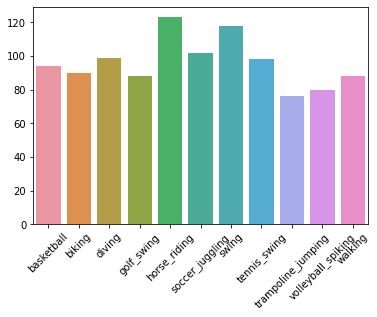

In [36]:
x_axis, y_axis = np.unique(y_train, return_counts=True)
sns.barplot(x=CLASSES, y=y_axis)
plt.xticks(rotation=45)
plt.show()

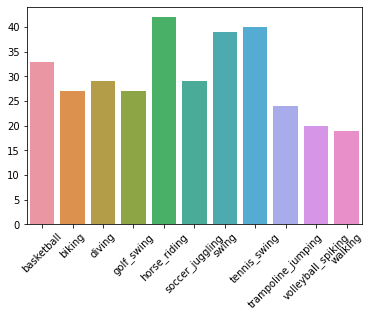

In [38]:
x_axis, y_axis = np.unique(y_val, return_counts=True)
sns.barplot(x=CLASSES, y=y_axis)
plt.xticks(rotation=45)
plt.show()

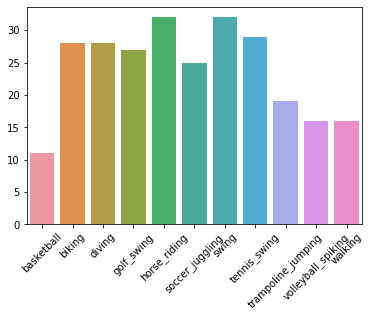

In [37]:
x_axis, y_axis = np.unique(y_test, return_counts=True)
sns.barplot(x=CLASSES, y=y_axis)
plt.xticks(rotation=45)
plt.show()

# Model

## Module

In [17]:
class Module(nn.Module):
    def __init__(self):
        super().__init__()
    
    def loss(self, y_hat, y):
        loss = nn.CrossEntropyLoss()

        # print(y_hat, y)

        # print(y_hat.shape, y.shape)

        return loss(y_hat, y)
    
    def optimizer(self, optimizer_type="SGD"):
        assert optimizer_type in ("SGD", "Adam"), f"optimizer_type must be SGD or Adam not {optimizer_type}"
        assert hasattr(self, "lr"), "Learning rate is not defined"
        assert hasattr(self, "weight_decay"), "Weight Decay rate is not defined"
        if optimizer_type == "SGD":
            assert hasattr(self, "momentum"), "Momentum is not defined"
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
          
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[60, 150], gamma=0.1)
        # scheduler=None

        return optimizer, scheduler
    
    def step(self, X_frames, X_keypoints, y):
        y_pred = self(X_frames, X_keypoints)
        return self.loss(y_pred, y), y_pred

## ConvLSTM

In [18]:
# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)
        # print(self.conv.weight)
        torch.nn.init.xavier_normal_(self.conv.weight)
        self.conv.bias.data.fill_(0.01)

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [19]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=DEVICE)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=DEVICE)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=DEVICE)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

## Architecture

In [20]:
class Seq2Seq(Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers, sequence_length, keypoints_length, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY):

        super(Seq2Seq, self).__init__()
                
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.keypoints_length = keypoints_length
        self.sequence_length = sequence_length

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        # self.sequential.add_module(
        #     "dropout1", nn.Dropout3d(p=0.5)
        # )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
            
            # self.sequential.add_module(
            #     f"dropout{l}", nn.Dropout3d(p=0.5)
            #     )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)
        # print(self.conv.weight)
        torch.nn.init.xavier_normal_(self.conv.weight)
        self.conv.bias.data.fill_(0.01)
          
        self.lstm_cell_layer_1 = nn.LSTMCell(self.keypoints_length, 512)

        self.lstm_cell_layer_2 = nn.LSTMCell(512, 512)
        
        self.fc = nn.Linear( (3 * 64 * 64) + 512, 11)

        torch.nn.init.xavier_normal_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def forward(self, X_frames, X_keypoints):

        output = self.sequential(X_frames)

        output = self.conv(output[:,:,-1])
        
        output = output.view(output.size(0), -1)

        hidden_state = torch.zeros(X_keypoints.size(0), 512).to(self.device)
        cell_state = torch.zeros(X_keypoints.size(0), 512).to(self.device)
        hidden_state_2 = torch.zeros(X_keypoints.size(0), 512).to(self.device)
        cell_state_2 = torch.zeros(X_keypoints.size(0), 512).to(self.device)

        torch.nn.init.xavier_normal_(hidden_state)
        torch.nn.init.xavier_normal_(cell_state)
        torch.nn.init.xavier_normal_(hidden_state_2)
        torch.nn.init.xavier_normal_(cell_state_2)

        out = X_keypoints.view(self.sequence_length, X_keypoints.size(0), -1)

        for i in range(self.sequence_length):
          hidden_state, cell_state = self.lstm_cell_layer_1(out[i], (hidden_state, cell_state))
          hidden_state_2, cell_state_2 = self.lstm_cell_layer_2(hidden_state, (hidden_state_2, cell_state_2))

        # print(output.shape, hidden_state_2.shape)
        # print(torch.cat((output, hidden_state_2), 1))
        # print((3 * 64 * 64) + 512)
        final_output = torch.cat((output, hidden_state_2), 1)
        
        final_output = self.fc(final_output)
        
        return final_output

## TRAINER

In [21]:
class Trainer():
    def __init__(self, epochs=10):
        self.epochs = epochs
        
    def prepare_model(self, model):
        model.trainer = self
        self.model = model
    def save_checkpoint(self, epoch):
        torch.save(self.model, os.path.join("drive/MyDrive/checkpoint", f"model_{epoch + 1}.pt"))
        with open(os.path.join("drive/MyDrive/checkpoint", f"history_{epoch + 1}.json"), 'w') as fp:
            json.dump(self.history, fp)
    
    def load_checkpoint(self, epoch):
        self.model = torch.load(os.path.join("drive/MyDrive/checkpoint", f"model_{epoch + 1}.pt"))
        with open(os.path.join("drive/MyDrive/checkpoint", f"history_{epoch + 1}.json"), "r") as json_file:
            self.history = json.load(json_file)
      
    def epoch_time(self, start_time, end_time):
        elapsed_time = start_time - end_time
        elapsed_mins = int(elapsed_time/60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    def fit(self, train_dataloader, val_dataloader, model):
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # self.device = 'cpu'
        highest_val = 0
        val_threshold = 0.71
        self.prepare_model(model)
        self.model.to(self.device)
        
        self.optimizer, self.scheduler = self.model.optimizer("Adam")
        
        self.history = {"train": {"loss": [], "accuracy": []}, "val": {"loss": [], "accuracy": []}}
        for epoch in range(0, self.epochs):
            
            start_time = time.time()
            train_loss, train_acc = self.fit_train(train_dataloader)
            val_loss, val_acc = self.fit_val(val_dataloader)
            end_time = time.time()

            self.scheduler.step()
            
            elapsed_mins, elapsed_secs = self.epoch_time( start_time, end_time)
            
            print(f"<---- Epoch {epoch + 1}: {elapsed_mins}m {elapsed_secs}s ---->")
            print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
            print(f"Val Loss: {val_loss}, Val Accuracy: {val_acc}")
            
            self.history["train"]["loss"].append(train_loss)
            self.history["train"]["accuracy"].append(train_acc)
            self.history["val"]["loss"].append(val_loss)
            self.history["val"]["accuracy"].append(val_acc)

            if val_acc > val_threshold:
              if val_acc > highest_val:
                highest_val = val_acc
                self.save_checkpoint(epoch + 1)
        
        self.model.to("cpu")
        
        return self.history
    def fit_train(self, train_dataloader):
        self.model.train()
        
        total_loss = 0
        accuracy = 0
        
        batchs = 0
        
        for X_frames, X_keypoints, y in train_dataloader:
            batchs += 1
            X_frames, X_keypoints, y = X_frames.to(self.device), X_keypoints.to(self.device), y.to(self.device)
            
            loss, y_pred = self.model.step(X_frames, X_keypoints, y)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            accuracy += accuracy_score(np.argmax(y_pred.to("cpu").detach().numpy(), axis=1).reshape(-1,1), y.to("cpu").detach().numpy().reshape(-1,1))
            
            del X_frames, X_keypoints, y, loss
                
        return total_loss / batchs, accuracy / batchs
    def fit_val(self, val_dataloader):
        assert hasattr(self, "model"), "Model is not yet defined"

        self.model.eval()
        total_loss = 0
        accuracy = 0

        batchs = 0

        for X_frames, X_keypoints, y in val_dataloader:
            batchs += 1
            X_frames, X_keypoints, y = X_frames.to(self.device), X_keypoints.to(self.device), y.to(self.device)

            with torch.no_grad():
                loss, y_pred = self.model.step(X_frames, X_keypoints, y)
                total_loss += loss.item()
                accuracy += accuracy_score(np.argmax(y_pred.to("cpu").detach().numpy(), axis=1).reshape(-1,1), y.to("cpu").detach().numpy().reshape(-1,1))
                del X_frames, X_keypoints, y, loss

        return total_loss / batchs, accuracy / batchs

    def evaluate(self, test_dataloader):
        
        assert hasattr(self, "model"), "Model is not yet defined"
        if not hasattr(self, "device"):
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        batchs = 0
        predictions = list()
        labels = list()
        for X_frames, X_keypoints, y in test_dataloader:
            batchs += 1
            X_frames, X_keypoints, y = X_frames.to(self.device), X_keypoints.to(self.device), y.to(self.device)

            with torch.no_grad():
                _, y_pred = self.model.step(X_frames, X_keypoints, y)
                y_pred = np.argmax(y_pred.to("cpu").detach().numpy(), axis=1).reshape(-1,1)
                y = y.to("cpu").detach().numpy().reshape(-1,1)
                predictions.extend(y_pred)
                labels.extend(y)
                accuracy = accuracy_score(y_pred, y)

                correct += accuracy

                del X_frames, X_keypoints, y


        return correct / batchs, np.array(predictions, dtype=object), np.array(labels, dtype=object)

## TRAINING

In [22]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=3, num_kernels=16, 
kernel_size=(5, 5), padding=(2, 2), activation="relu", 
frame_size=(64, 64), num_layers=2, sequence_length=20, keypoints_length=1662).to(DEVICE)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

7174718

In [33]:
print(model)

Seq2Seq(
  (sequential): Sequential(
    (convlstm1): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(19, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
    (batchnorm1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm2): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
    (batchnorm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(16, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lstm_cell_layer_1): LSTMCell(1662, 512)
  (lstm_cell_layer_2): LSTMCell(512, 512)
  (fc): Linear(in_features=12800, out_features=11, bias=True)
)


In [24]:
EPOCHS=200
trainer = Trainer(epochs=EPOCHS)
history = trainer.fit(train_dataloader, test_dataloader, model)

<---- Epoch 1: 0m -34s ---->
Train Loss: 4.794933795928955, Train Accuracy: 0.19025735294117646
Val Loss: 2.41970009803772, Val Accuracy: 0.1
<---- Epoch 2: 0m -27s ---->
Train Loss: 2.6868588784161735, Train Accuracy: 0.3318014705882353
Val Loss: 2.410547161102295, Val Accuracy: 0.12544642857142857
<---- Epoch 3: 0m -27s ---->
Train Loss: 1.999521304579342, Train Accuracy: 0.43474264705882354
Val Loss: 2.3567006587982178, Val Accuracy: 0.20357142857142857
<---- Epoch 4: 0m -27s ---->
Train Loss: 1.4446458115297205, Train Accuracy: 0.5560661764705882
Val Loss: 2.2826026678085327, Val Accuracy: 0.28214285714285714
<---- Epoch 5: 0m -27s ---->
Train Loss: 1.0945818213855518, Train Accuracy: 0.6516544117647058
Val Loss: 2.0156840085983276, Val Accuracy: 0.36919642857142854
<---- Epoch 6: 0m -27s ---->
Train Loss: 0.8878033196224886, Train Accuracy: 0.7178308823529411
Val Loss: 1.8413636922836303, Val Accuracy: 0.5138392857142857
<---- Epoch 7: 0m -27s ---->
Train Loss: 0.7630745102377499,

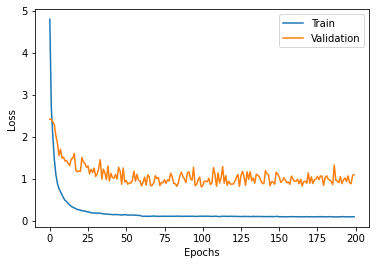

In [25]:
g1 = sns.lineplot(x=range(0, 200), y=history["train"]["loss"])
g2 = sns.lineplot(x=range(0, 200), y=history["val"]["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

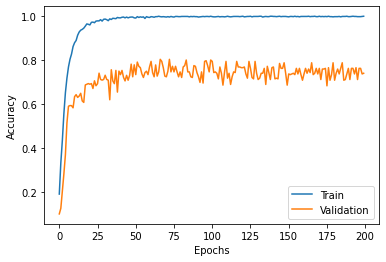

In [26]:
g1 = sns.lineplot(x=range(0, 200), y=history["train"]["accuracy"])
g2 = sns.lineplot(x=range(0, 200), y=history["val"]["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

In [42]:
trainer = Trainer(epochs=EPOCHS)
trainer.load_checkpoint(epoch=73)

In [43]:
acc, y_pred, y = trainer.evaluate(test_dataloader)
print(f"Test Accuracy: {acc}")

Test Accuracy: 0.7776785714285714


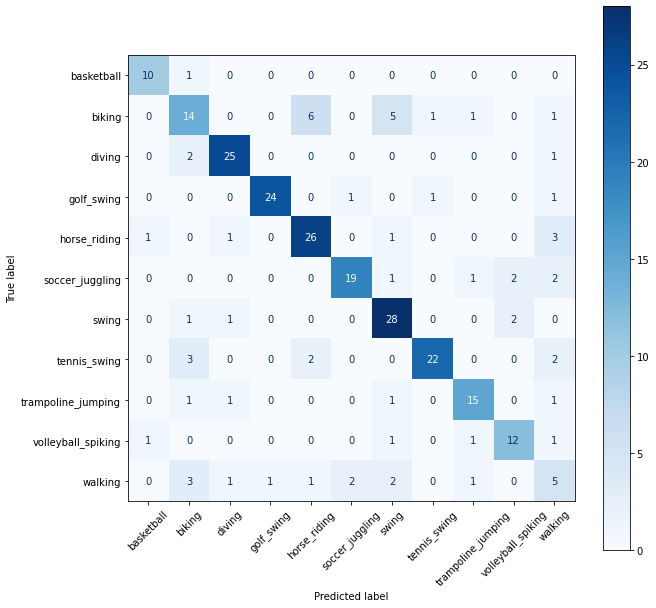

In [45]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)
cm = confusion_matrix(y.astype(int), y_pred.astype(int))
cm = ConfusionMatrixDisplay(cm, display_labels = CLASSES)
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 45)
plt.show()